# No control

Compare peak calling results without / with peaks

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    t = df_span[['_200_' in f for f in df_span['file']]]
    if len(t) != 0:
        df_span = t  # Fallback to 100bp
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True
df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True
df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False
df_peaks = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/49 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset,control
478,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K4me3,NHLF,rep2,37142,MACS2 broad,ENCODE,False
479,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27me3,Huvec,rep1,7424,MACS2 broad,ENCODE,False
131,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27me3,K562,rep2,18762,MACS2 broad,ENCODE,True


In [8]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

ENCODE


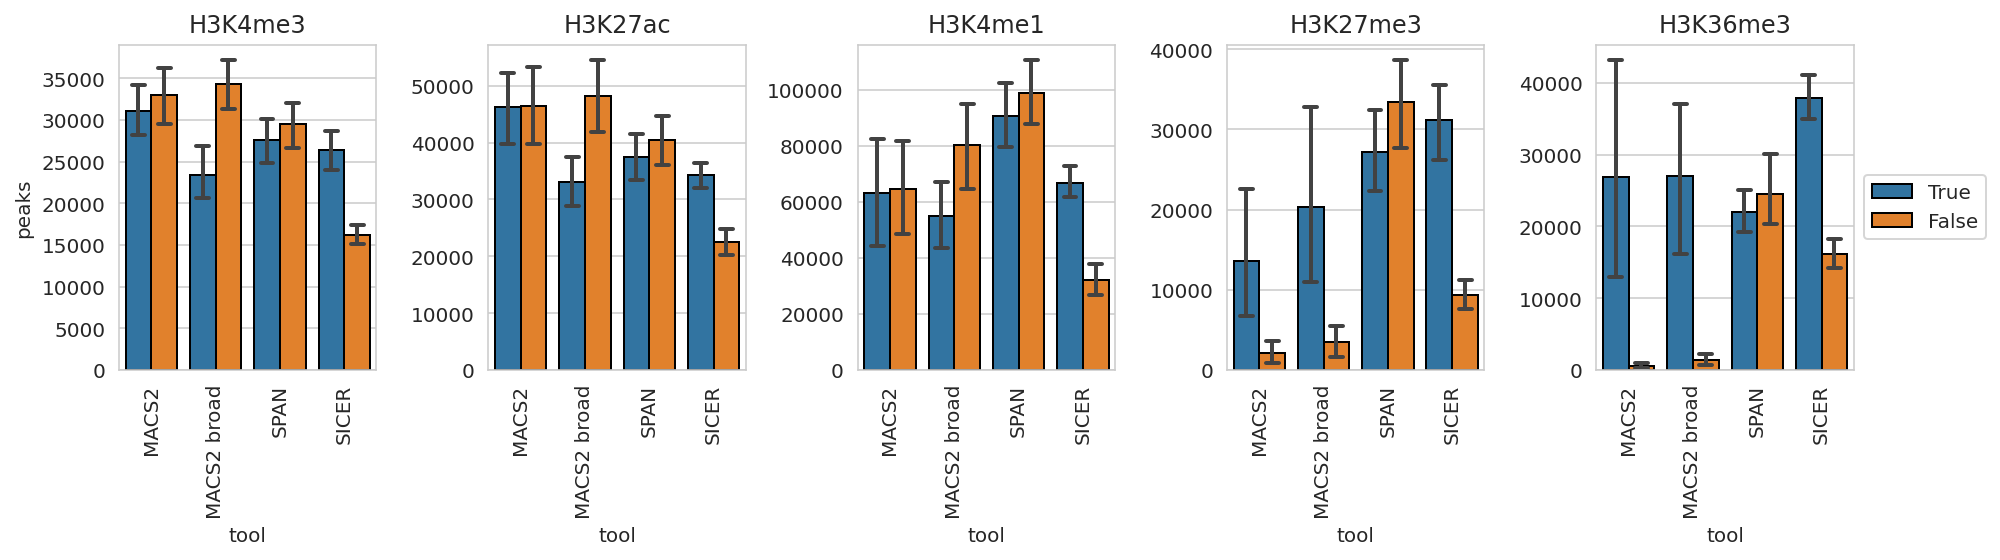

Roadmap


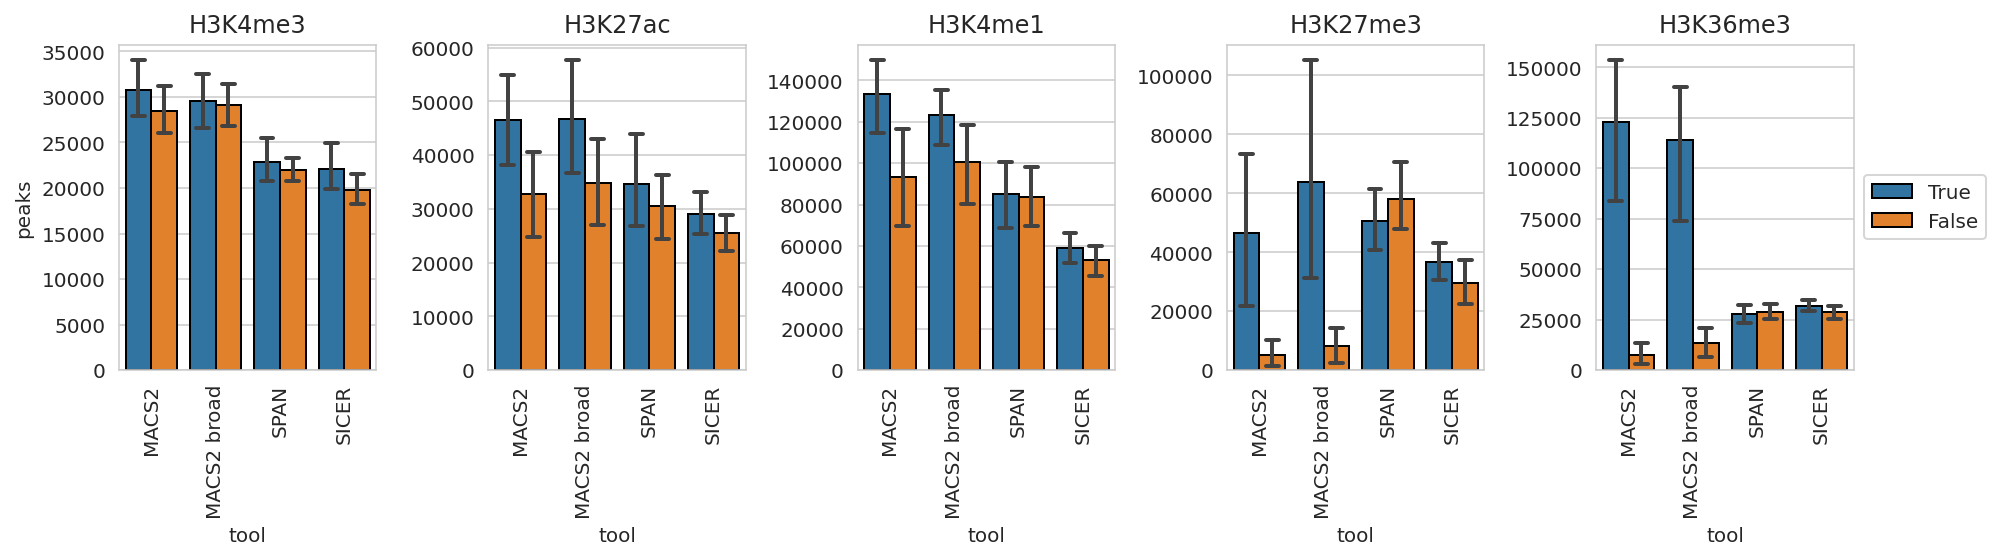

In [9]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        g_results = sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) & 
                                              (df_peaks['modification'] == m)], x='tool', y='peaks', ax=ax,
                                hue='control',
                                capsize=.2, errwidth=2, edgecolor="black",
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                hue_order=[True, False])
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Compute ratio no control vs control

In [10]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,ratio
221,ENCODE,H3K4me1,HMEC,rep2,MACS2 broad,44
187,ENCODE,H3K36me3,K562,rep2,SPAN,8
482,Roadmap,H3K4me3,CD4ABT,rep2,SICER,-8


ENCODE


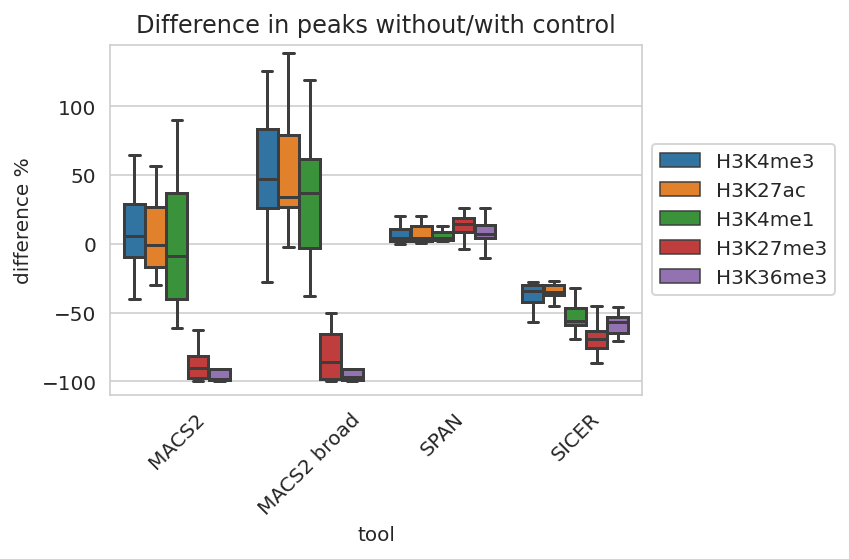

Roadmap


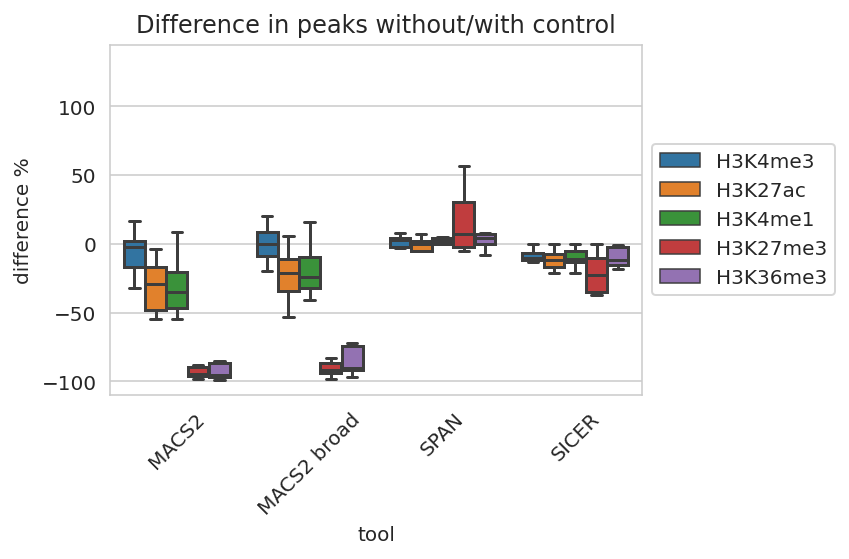

In [11]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    g_results = sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                            x='tool', y='ratio', hue='modification',
                            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            showfliers=False
                            )
    ax = g_results.axes
    ax.set_ylabel('difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-110, 145)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Jaccard without control vs with control

In [12]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, jaccard))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'jaccard'])
del rows
df_ratio.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,jaccard
305,ENCODE,H3K4me3,Huvec,rep1,MACS2 broad,0.518398
432,Roadmap,H3K4me1,BCell,,MACS2,0.473452
31,ENCODE,H3K27ac,HepG2,rep1,SPAN,0.834350


ENCODE


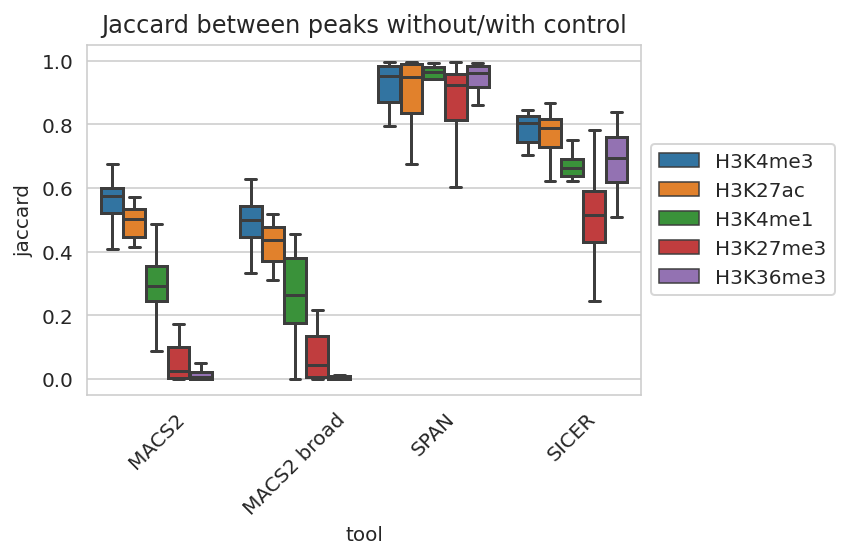

Roadmap


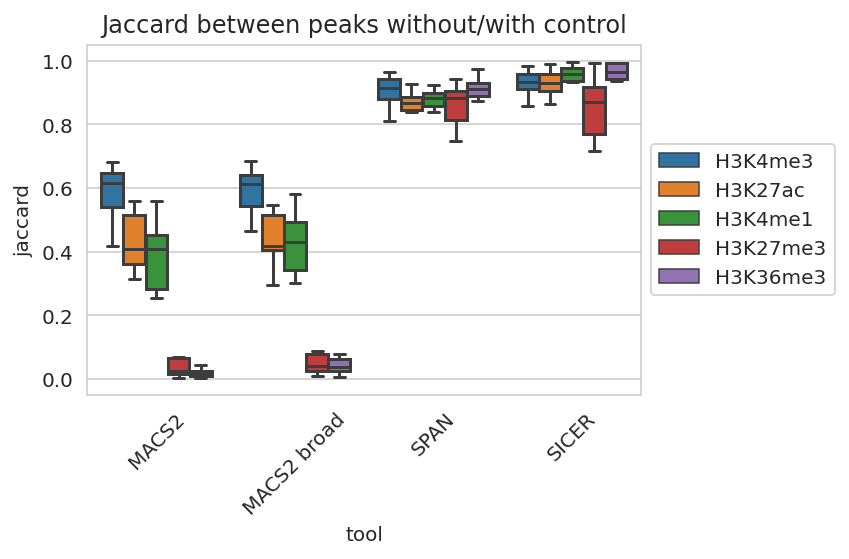

In [13]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    g_results = sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                            x='tool', y='jaccard', hue='modification',
                            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            showfliers=False
                            )
    ax = g_results.axes
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [14]:
df_ratio[(df_ratio['dataset'] == 'Roadmap') & 
         (df_ratio['modification'] == 'H3K27me3') & 
         (df_ratio['jaccard'] < 0.2)]

,dataset,modification,cell,replicate,tool,jaccard
368,Roadmap,H3K27me3,BCell,,MACS2,0.064462
369,Roadmap,H3K27me3,BCell,,MACS2 broad,0.073318
372,Roadmap,H3K27me3,CD34,,MACS2,0.018710
373,Roadmap,H3K27me3,CD34,,MACS2 broad,0.030661
376,Roadmap,H3K27me3,CD34,rep2,MACS2,0.026663
377,Roadmap,H3K27me3,CD34,rep2,MACS2 broad,0.035925
380,Roadmap,H3K27me3,CD4,,MACS2,0.004436
381,Roadmap,H3K27me3,CD4,,MACS2 broad,0.011033
384,Roadmap,H3K27me3,CD4,rep2,MACS2,0.005441
385,Roadmap,H3K27me3,CD4,rep2,MACS2 broad,0.009088
